In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Trial_2
[Reference- github(by vishnu)](https://medium.com/analytics-vidhya/multi-task-learning-in-computer-vision-image-classification-ea7b61fb4a0a/)

In [ ]:
#import tensorflow as tf
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [ ]:
! pip install onnx

     |████████████████████████████████| 12.7 MB 5.4 MB/s 


In [ ]:
! pip install onnx2keras

  Created wheel for onnx2keras: filename=onnx2keras-0.0.24-py3-none-any.whl size=24593 sha256=9ac0c54faecb6f97f55701acb6071356b14a8457dee3c89e6c54ca5af061298b
  Stored in directory: /root/.cache/pip/wheels/21/29/29/227fc9f8fed234b12169ae41f979cfadf1dcdbe1b370a5bbb5
Successfully built onnx2keras


In [ ]:
! pip install onnxruntime

     |████████████████████████████████| 4.9 MB 5.5 MB/s 


In [ ]:
from torch.autograd import Variable
import onnx

#Training in Keras (ICIAR) : Densenet, Efficientnet

In [ ]:
import tensorflow as tf
import keras
from keras import callbacks
from keras import optimizers
#from keras.engine import Model
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, DenseNet169, EfficientNetB2, EfficientNetB0, ResNet50, ResNet50V2
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        rotation_range=40,
        height_shift_range=0.2,
        zoom_range=0.2)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    directory="/content/drive/My Drive/ICIAR/Stained_images/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=4,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = valid_datagen.flow_from_directory(
    directory="/content/drive/My Drive/ICIAR/Random40_orig/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=4,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 2400 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [ ]:
input_shape = (224,224,3)
base_model = ResNet50V2(weights='imagenet', include_top=True, input_shape=input_shape)
base_model.summary()

102883328/102869336 [==============================] - 4s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

In [ ]:
#for layer in base_model.layers:
#  layer.trainable = True
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
from tensorflow.keras import regularizers
initializer = tf.keras.initializers.HeNormal()

In [ ]:
import tensorflow_hub as hub
inputs = tf.keras.layers.Input(shape=[224, 224, 3])

#main = model1(inputs)
#x = Flatten()(base_model.layers[-2].output)
#x = Dense(1024, activation='relu', name='fc1')(x)
x = Dropout(0.1)(base_model.layers[-2].output)
x = Dense(2, activation='softmax', name='predictions', kernel_initializer=initializer)(x)
model = tf.keras.Model(base_model.inputs, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

epochs = 70
batch_size = 16
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
      decay_steps =2400, decay_rate = 0.7,
    initial_learning_rate=1e-3)


opt = keras.optimizers.SGD(learning_rate= 0.001)
#opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
#min_delta = 0, mode="auto", baseline=None, restore_best_weights=False
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)

#callbacks_list = [reduce_lr]

model.compile(optimizer=opt ,  #rmsprop #sgd
              loss='categorical_crossentropy',  metrics=['accuracy']) #, callbacks=callbacks_list

history = model.fit(train_generator,
          epochs=epochs, verbose=1,  validation_data = valid_generator)  #batch_size=batch_size,

Epoch 1/70
600/600 [==============================] - 681s 1s/step - loss: 0.6068 - accuracy: 0.6725 - val_loss: 0.6352 - val_accuracy: 0.6000
Epoch 2/70
600/600 [==============================] - 86s 143ms/step - loss: 0.5055 - accuracy: 0.7600 - val_loss: 0.4947 - val_accuracy: 0.8000
Epoch 3/70
600/600 [==============================] - 85s 142ms/step - loss: 0.4322 - accuracy: 0.8000 - val_loss: 0.5012 - val_accuracy: 0.7750
Epoch 4/70
600/600 [==============================] - 85s 142ms/step - loss: 0.3815 - accuracy: 0.8346 - val_loss: 0.5967 - val_accuracy: 0.7500
Epoch 5/70
600/600 [==============================] - 85s 142ms/step - loss: 0.3232 - accuracy: 0.8621 - val_loss: 0.6165 - val_accuracy: 0.7250
Epoch 6/70
600/600 [==============================] - 85s 142ms/step - loss: 0.2952 - accuracy: 0.8729 - val_loss: 0.6128 - val_accuracy: 0.8000
Epoch 7/70
600/600 [==============================] - 85s 142ms/step - loss: 0.2616 - accuracy: 0.8896 - val_loss: 0.5907 - val_accu

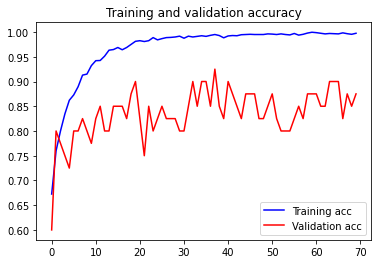

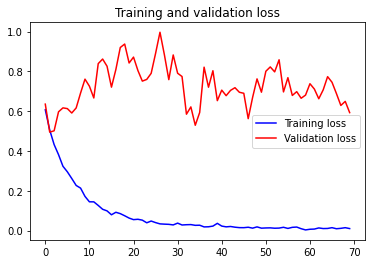

In [ ]:
import matplotlib.pyplot as plt
# Utility function for plotting of the model results
def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

In [ ]:
model.save("/content/drive/My Drive/ICIAR/new_models/r18m2.h5", )

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/My Drive/ICIAR/new_models/r18m2.h5')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
test_generator = test_datagen.flow_from_directory(
    directory="/content/drive/My Drive/ICIAR/New_test/",
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
nBatches = 120

Found 120 images belonging to 2 classes.


In [ ]:
score = model.evaluate_generator(generator=test_generator,              # Generator yielding tuples
                                                                        # number of steps (batches of samples) to yield from generator before stopping
                                     max_queue_size=10,                 # maximum size for the generator queue
                                     workers=1,                         # maximum number of processes to spin up when using process based threading
                                     use_multiprocessing=False,         # whether to use process-based threading
                                     verbose=1)
print("Test loss: %.3f - Test acc: %.3f" % (score[0], score[1]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


120/120 [==============================] - 5s 30ms/step - loss: 0.9779 - accuracy: 0.8417
Test loss: 0.978 - Test acc: 0.842


In [ ]:
test_generator.reset()

In [ ]:
test_generator.class_indices

In [ ]:
pred=model.predict_generator(test_generator,verbose=1)

In [ ]:
predicted_class_indices=np.argmax(pred,axis=1)

In [ ]:
labels = (test_generator.labels)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(labels, predicted_class_indices)
print('Confusion Matrix\n')
print(confusion)

In [ ]:
#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(labels, predicted_class_indices)))

print('Micro Precision: {:.2f}'.format(precision_score(labels, predicted_class_indices, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(labels, predicted_class_indices, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(labels, predicted_class_indices, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(labels, predicted_class_indices, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(labels, predicted_class_indices, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(labels, predicted_class_indices, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(labels, predicted_class_indices, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(labels, predicted_class_indices, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(labels, predicted_class_indices, average='weighted')))


from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(labels, predicted_class_indices, target_names=['Class 1', 'Class 2']))


Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.85
Macro Recall: 0.84
Macro F1-score: 0.84

Weighted Precision: 0.85
Weighted Recall: 0.84
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

     Class 1       0.81      0.90      0.85        60
     Class 2       0.89      0.78      0.83        60

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120


Accuracy: 0.84

Micro Precision: 0.84
Micro Recall: 0.84
Micro F1-score: 0.84

Macro Precision: 0.85
Macro Recall: 0.84
Macro F1-score: 0.84

Weighted Precision: 0.85
Weighted Recall: 0.84
Weighted F1-score: 0.84

Classification Report

              precision    recall  f1-score   support

     Class 1       0.81      0.90      0.85        60
     Class 2       0.89      0.78      0.83        60

    accuracy                     

#PyTorch --> ONNX --> Keras

In [ ]:
import torch


model = torch.load('/content/drive/My Drive/ICIAR_Breakhis_models/resnet101_m2.pt')
if torch.cuda.is_available():
    model.cuda()
model.eval()
dummy_input = torch.randn(1, 3, 224, 224)
dummy_input  = dummy_input.cuda()
input_names = ["actual_input"]
output_names = ["output"]
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#dummy_input, output_names = dummy_input.to(device), output_names.to(device)

In [ ]:
torch.onnx.export(model,
                  dummy_input,
                  "/content/drive/My Drive/ICIAR_Breakhis_models/resnet101_m2.onnx",
                  verbose=False,
                  input_names=input_names,
                  output_names=output_names,
                  export_params=True,
                  )

In [ ]:
from onnx2keras import onnx_to_keras
# Load ONNX model
onnx_model = onnx.load('/content/drive/My Drive/ICIAR_Breakhis_models/resnet101_m2.onnx')
# Call the converter (input will be equal to the input_names parameter that you defined during exporting)
k_model = onnx_to_keras(onnx_model, ["actual_input"], input_shapes=[(3, 224, 224)], name_policy="short", verbose=True, change_ordering=True)
k_model.summary()

INFO:onnx2keras:Converter is called.
DEBUG:onnx2keras:List input shapes:
DEBUG:onnx2keras:[(3, 224, 224)]
DEBUG:onnx2keras:List inputs:
DEBUG:onnx2keras:Input 0 -> actual_input.
DEBUG:onnx2keras:List outputs:
DEBUG:onnx2keras:Output 0 -> output.
DEBUG:onnx2keras:Gathering weights to dictionary.
DEBUG:onnx2keras:Found weight fc.0.weight with shape (256, 2048).
DEBUG:onnx2keras:Found weight fc.0.bias with shape (256,).
DEBUG:onnx2keras:Found weight fc.3.weight with shape (2, 256).
DEBUG:onnx2keras:Found weight fc.3.bias with shape (2,).
DEBUG:onnx2keras:Found weight 978 with shape (64, 3, 7, 7).
DEBUG:onnx2keras:Found weight 979 with shape (64,).
DEBUG:onnx2keras:Found weight 981 with shape (64, 64, 1, 1).
DEBUG:onnx2keras:Found weight 982 with shape (64,).
DEBUG:onnx2keras:Found weight 984 with shape (64, 64, 3, 3).
DEBUG:onnx2keras:Found weight 985 with shape (64,).
DEBUG:onnx2keras:Found weight 987 with shape (256, 64, 1, 1).
DEBUG:onnx2keras:Found weight 988 with shape (256,).
DEBUG:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 actual_input (InputLayer)      [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 977_pad (ZeroPadding2D)        (None, 230, 230, 3)  0           ['actual_input[0][0]']           
                                                                                                  
 977 (Conv2D)                   (None, 112, 112, 64  9472        ['977_pad[0][0]']                
                                )                                                                 
                                                                                              

#Part 2: BreaKHis

In [ ]:
from __future__ import print_function  #do it
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
from torch.utils.data import Subset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.optim.lr_scheduler import ExponentialLR, StepLR, ReduceLROnPlateau
from sklearn import metrics
from torch.nn import functional as F
import cv2
import tensorflow as tf


import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

#from mtdp import build_model
#from mtdp.helpers import compute_loss, rescale_head_grads
#from mtdp.loader import MultiImageFolders
#from mtdp.networks import MultiHead

import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)





# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


Training data

In [ ]:
data_dir = '/content/drive/My Drive/BreaKHis2_8_trial/BreaKHis8_train/'
list_of_data = []
img_size = 224      #128 earlier
for fol in os.listdir(data_dir):
    for file in os.listdir(os.path.join(data_dir, fol)):
        json_dict = {}
        img_arr = cv2.imread(os.path.join(os.path.join(data_dir, fol), file))#[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        json_dict['image'] = resized_arr
        json_dict['class_1'] = fol.split('_')[0]
        json_dict['class_2'] = fol.split('_')[1]
        list_of_data.append(json_dict)

x_train = []
y_train = []
print(list_of_data)

for i in range(0, len(list_of_data)):     #train.shape[0]
    x_train.append(list_of_data[i]['image'])
    y_train.append([list_of_data[i]['class_1'], list_of_data[i]['class_2']])

x_train = np.array(x_train) / 255
x_train.reshape(x_train.shape[0],3, img_size, img_size)

print(x_train)

Streaming output truncated to the last 5000 lines.
        [177,  96, 212],
        [177,  96, 212],
        [177,  96, 212]],

       [[210, 195, 218],
        [210, 195, 218],
        [210, 195, 218],
        ...,
        [177,  96, 212],
        [177,  96, 212],
        [177,  96, 212]],

       ...,

       [[132,  41, 199],
        [132,  41, 199],
        [132,  41, 199],
        ...,
        [168,  44, 243],
        [168,  44, 243],
        [168,  44, 243]],

       [[132,  41, 199],
        [132,  41, 199],
        [132,  41, 199],
        ...,
        [168,  44, 243],
        [168,  44, 243],
        [168,  44, 243]],

       [[132,  41, 199],
        [132,  41, 199],
        [132,  41, 199],
        ...,
        [168,  44, 243],
        [168,  44, 243],
        [168,  44, 243]]], dtype=uint8), 'class_1': 'malignant', 'class_2': 'mucinouscarcinoma'}, {'image': array([[[130,  16, 160],
        [130,  16, 160],
        [130,  16, 160],
        ...,
        [181, 100, 194],
     

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [ ]:
y_train = np.array(y_train)
class_1 = y_train[:,0]
class_2 = y_train[:,1]
c_1 = len(set(class_1))
c_2 = len(set(class_2))

map_1 = {}
for i, j in enumerate(list(set(class_1))):
    map_1[j] = i

map_2 = {}
for i, j in enumerate(list(set(class_2))):
    map_2[j] = i

class_arr1 = []
for x in class_1:
    class_arr1.append(map_1[x])
class_arr1 = np.array(class_arr1)

class_arr2 = []
for x in class_2:
    class_arr2.append(map_2[x])
class_arr2 = np.array(class_arr2)

Validation data

In [ ]:
val_dir = '/content/drive/My Drive/BreaKHis2_8_trial/BreaKHis8_val/'
list_of_data = []
img_size = 224      #128 earlier
for fol in os.listdir(val_dir):
    for file in os.listdir(os.path.join(val_dir, fol)):
        json_dict = {}
        img_arr = cv2.imread(os.path.join(os.path.join(val_dir, fol), file))#[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        json_dict['image'] = resized_arr
        json_dict['class_1'] = fol.split('_')[0]
        json_dict['class_2'] = fol.split('_')[1]
        list_of_data.append(json_dict)

x_val = []
y_val = []
print(list_of_data)

for i in range(0, len(list_of_data)):     #train.shape[0]
    x_val.append(list_of_data[i]['image'])
    y_val.append([list_of_data[i]['class_1'], list_of_data[i]['class_2']])

x_val = np.array(x_val) / 255
x_val.reshape(x_val.shape[0], 3,img_size, img_size)

print("x_val shape: ", x_val.shape)
print(x_val)

[{'image': array([[[183, 158, 190],
        [183, 158, 190],
        [183, 158, 190],
        ...,
        [175, 149, 189],
        [175, 149, 189],
        [175, 149, 189]],

       [[183, 158, 190],
        [183, 158, 190],
        [183, 158, 190],
        ...,
        [175, 149, 189],
        [175, 149, 189],
        [175, 149, 189]],

       [[183, 158, 190],
        [183, 158, 190],
        [183, 158, 190],
        ...,
        [175, 149, 189],
        [175, 149, 189],
        [175, 149, 189]],

       ...,

       [[185, 155, 204],
        [185, 155, 204],
        [185, 155, 204],
        ...,
        [187, 146, 209],
        [187, 146, 209],
        [187, 146, 209]],

       [[185, 155, 204],
        [185, 155, 204],
        [185, 155, 204],
        ...,
        [187, 146, 209],
        [187, 146, 209],
        [187, 146, 209]],

       [[185, 155, 204],
        [185, 155, 204],
        [185, 155, 204],
        ...,
        [187, 146, 209],
        [187, 146, 209],
        [187,

In [ ]:
y_val = np.array(y_val)
vclass_1 = y_val[:,0]
vclass_2 = y_val[:,1]
vc_1 = len(set(vclass_1))
vc_2 = len(set(vclass_2))

map_1 = {}
for i, j in enumerate(list(set(vclass_1))):
    map_1[j] = i

map_2 = {}
for i, j in enumerate(list(set(vclass_2))):
    map_2[j] = i

val_class_arr1 = []
for x in vclass_1:
    val_class_arr1.append(map_1[x])
val_class_arr1 = np.array(val_class_arr1)

val_class_arr2 = []
for x in vclass_2:
    val_class_arr2.append(map_2[x])
val_class_arr2 = np.array(val_class_arr2)

In [ ]:
from tensorflow import keras
base_model = keras.models.load_model('/content/drive/My Drive/FEW_SHOT_MULTI_TASK/k_iciar_enetb0_m1/model1.h5')

In [ ]:
from keras.models import Model
model= Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_5[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

In [ ]:
import keras
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

In [ ]:
import tensorflow_hub as hub
inputs = tf.keras.layers.Input(shape=[224, 224, 3], name='main_input')

main_branch = model(inputs)

#main_branch = hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2")(inputs)
main_branch = tf.keras.layers.Flatten()(main_branch)
main_branch = tf.keras.layers.Dense(1024, activation='relu')(main_branch)
primary_branch = tf.keras.layers.Dense(c_1, activation='softmax', name='primary_output')(main_branch)
finegrain_branch = tf.keras.layers.Dense(c_2, activation='softmax', name='finegrain_output')(main_branch)      #auto
model = tf.keras.Model(inputs = inputs,
outputs = [primary_branch, finegrain_branch])

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=100,
    decay_rate=0.9)

#opt = keras.optimizers.SGD(learning_rate= lr_schedule)
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)

model.compile(optimizer=opt ,  #rmsprop #sgd
              loss={'primary_output': 'sparse_categorical_crossentropy', 'finegrain_output': 'sparse_categorical_crossentropy'},
              loss_weights={'primary_output': .01, 'finegrain_output': 1.5},  metrics=['accuracy'])

model.fit({'main_input': x_train},
          {'primary_output': class_arr1, 'finegrain_output': class_arr2},
          epochs=40, batch_size=16,  #128
          verbose=1,  validation_data = ({'main_input': x_val},
          {'primary_output': val_class_arr1, 'finegrain_output': val_class_arr2}))
          #(validation_split=0.2)

Epoch 1/40
30/30 [==============================] - 47s 603ms/step - loss: 4.9935 - primary_output_loss: 0.7351 - finegrain_output_loss: 3.3241 - primary_output_accuracy: 0.5458 - finegrain_output_accuracy: 0.1562 - val_loss: 3583.7085 - val_primary_output_loss: 17.6581 - val_finegrain_output_loss: 2389.0212 - val_primary_output_accuracy: 0.3750 - val_finegrain_output_accuracy: 0.1250
Epoch 2/40
30/30 [==============================] - 14s 463ms/step - loss: 3.3101 - primary_output_loss: 0.6446 - finegrain_output_loss: 2.2024 - primary_output_accuracy: 0.6521 - finegrain_output_accuracy: 0.2104 - val_loss: 4.6812 - val_primary_output_loss: 1.4079 - val_finegrain_output_loss: 3.1114 - val_primary_output_accuracy: 0.5000 - val_finegrain_output_accuracy: 0.1250
Epoch 3/40
30/30 [==============================] - 14s 464ms/step - loss: 3.1208 - primary_output_loss: 0.5798 - finegrain_output_loss: 2.0767 - primary_output_accuracy: 0.7042 - finegrain_output_accuracy: 0.2417 - val_loss: 94.43

In [ ]:
model.save('/content/drive/My Drive/FEW_SHOT_MULTI_TASK/mtl_enetb0_m1/')
#model.save('/content/drive/My Drive/Few_shot_models/fewshot1.h5')

INFO:tensorflow:Assets written to: /content/drive/My Drive/FEW_SHOT_MULTI_TASK/K_mtl_dnet121_m1/assets


In [ ]:
from tensorflow import keras
loaded_model = keras.models.load_model('/content/drive/My Drive/FEW_SHOT_MULTI_TASK/mtl_enetb0_m1/')

print(loaded_model.layers[0].input_shape)
print()
print("-----------------")
print()
print(model.summary())

[(None, 224, 224, 3)]

-----------------

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_4 (Functional)           (None, 1024)         7037504     ['main_input[0][0]']             
                                                                                                  
 flatten (Flatten)              (None, 1024)         0           ['model_4[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)      

Testing accuracy and loss

In [ ]:
test_dir = '/content/drive/My Drive/BreaKHis2_8_trial/BreaKHis8_test/'
list_of_data = []
img_size = 224      #128 earlier
for fol in os.listdir(test_dir):
    for file in os.listdir(os.path.join(test_dir, fol)):
        json_dict = {}
        img_arr = cv2.imread(os.path.join(os.path.join(test_dir, fol), file))#[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        json_dict['image'] = resized_arr
        json_dict['class_1'] = fol.split('_')[0]
        json_dict['class_2'] = fol.split('_')[1]
        list_of_data.append(json_dict)

x_test = []
y_test = []
print(list_of_data)

for i in range(0, len(list_of_data)):     #train.shape[0]
    x_test.append(list_of_data[i]['image'])
    y_test.append([list_of_data[i]['class_1'], list_of_data[i]['class_2']])

x_test = np.array(x_test) / 255
x_test.reshape(x_test.shape[0], img_size, img_size, 3)

print("x_test shape: ", x_test.shape)
print(x_test)

Streaming output truncated to the last 5000 lines.
        [169, 142, 203],
        [169, 142, 203]],

       [[184, 159, 214],
        [184, 159, 214],
        [184, 159, 214],
        ...,
        [169, 142, 203],
        [169, 142, 203],
        [169, 142, 203]],

       ...,

       [[221, 215, 226],
        [221, 215, 226],
        [221, 215, 226],
        ...,
        [199, 195, 207],
        [199, 195, 207],
        [199, 195, 207]],

       [[221, 215, 226],
        [221, 215, 226],
        [221, 215, 226],
        ...,
        [199, 195, 207],
        [199, 195, 207],
        [199, 195, 207]],

       [[221, 215, 226],
        [221, 215, 226],
        [221, 215, 226],
        ...,
        [199, 195, 207],
        [199, 195, 207],
        [199, 195, 207]]], dtype=uint8), 'class_1': 'malignant', 'class_2': 'lobularcarcinoma'}, {'image': array([[[180, 157, 221],
        [180, 157, 221],
        [180, 157, 221],
        ...,
        [219, 217, 229],
        [219, 217, 229],
      

In [ ]:
y_test = np.array(y_test)
tclass_1 = y_test[:,0]
tclass_2 = y_test[:,1]
tc_1 = len(set(tclass_1))
tc_2 = len(set(tclass_2))

map_1 = {}
for i, j in enumerate(list(set(tclass_1))):
    map_1[j] = i

map_2 = {}
for i, j in enumerate(list(set(tclass_2))):
    map_2[j] = i

test_class_arr1 = []
for x in tclass_1:
    test_class_arr1.append(map_1[x])
test_class_arr1 = np.array(test_class_arr1)

test_class_arr2 = []
for x in tclass_2:
    test_class_arr2.append(map_2[x])
test_class_arr2 = np.array(test_class_arr2)

In [ ]:
results = loaded_model.evaluate({'main_input': x_test},
          {'primary_output': test_class_arr1, 'finegrain_output': test_class_arr2}, batch_size=128)
print("test loss, test acc:", results)

15/15 [==============================] - 21s 884ms/step - loss: 16.1583 - primary_output_loss: 2.0890 - finegrain_output_loss: 10.7583 - primary_output_accuracy: 0.5757 - finegrain_output_accuracy: 0.1477
test loss, test acc: [16.158309936523438, 2.0889663696289062, 10.758280754089355, 0.5756929516792297, 0.14765457808971405]


#extra
Getting predictions

In [ ]:
dir_2 = '/content/drive/My Drive/BreaKHis2_8_trial/BreaKHis8_test/adenosis/'
test_list = []
for file in os.listdir(dir_2):
    if file.split('.')[1] != 'ipynb':
        json_dict = {}
        img_arr = cv2.imread(os.path.join(dir_2, file))#[...,::-1] #convert BGR to RGB format
        resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
        json_dict['image'] = resized_arr
        test_list.append(json_dict)
test = np.array(test_list)
x_test = []
for i in range(0, len(test_list)):
    x_test.append(test_list[i]['image'])
x_test = np.array(x_test) / 255
x_test.reshape(x_test.shape[0], img_size, img_size, 3)
x_test.shape

IndexError: ignored

In [ ]:
preds = loaded_model.predict(x_test)
c1 = []
c2 = []
for i in range(0, preds[0].shape[0]):
c1.append(np.argmax(preds[0][i]))
c2.append(np.argmax(preds[1][i]))
re_map1 = {}
for k, v in map_1.items():
re_map1[v] = k
re_map2 = {}
for k, v in map_2.items():
re_map2[v] = k


(later on)
ICIAR : 1400x1400 --> crop into few patches say 465x465--> then resize say 220

upload code on github

5th december - first draft of the paper


ResNet101: https://tfhub.dev/google/bit/m-r101x1/imagenet21k_classification/1

Resnet152: https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/5

EfficientNet: https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2

DenseNet: